In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from itertools import product
from competition.titanic.FeaturesEngineering import *
from xgboost import XGBClassifier
import warnings

warnings.filterwarnings("error", category=FutureWarning)

from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv("../data/train.csv", delimiter=",")

features = [x for x in df.columns if x != "Survived"]
x, y = df[features], df["Survived"].T
print(x.shape)
print(y.shape)

(891, 11)
(891,)


In [3]:
X_train, X_cv, y_train, y_cv = train_test_split(x, y, train_size=0.8, random_state=1)

In [4]:
# Max depth: 3, n_estimators: 140, min_child_weight: 10, colsample_bytree: 0.4,reg_lambda: 0.1,reg_alpha: 0.5, train_accuracy: 0.8764044943820225, cv_accuracy: 0.8044692737430168

# colsample_bytree_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
# train_acc = []
# cv_acc = []
# for colsample_bytree in colsample_bytree_list:
#     model = Pipeline(steps=[
#         ("preprocessor", engineer_features()),
#         ("classifier", XGBClassifier(n_estimators=140,
#                                      learning_rate=0.1,
#                                      max_depth=3,
#                                      min_child_weight=10,
#                                      colsample_bytree=0.2,
#                                      reg_lambda=0.1,
#                                      reg_alpha=0.5,
#                                      random_state=1))
#     ])
#     model.fit(X_train, y_train)
#     y_train_hat = model.predict(X_train)
#     train_accuracy = np.mean(y_train == y_train_hat)
#     y_cv_hat = model.predict(X_cv)
#     cv_accuracy = np.mean(y_cv == y_cv_hat)
#     train_acc.append(train_accuracy)
#     cv_acc.append(cv_accuracy)
#     print(f"colsample_bytree: {colsample_bytree}, train_accuracy {train_accuracy}, cv_accuracy: {cv_accuracy}")
#
# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.plot(colsample_bytree_list, train_acc)
# plt.plot(colsample_bytree_list, cv_acc)
# plt.xlabel("min_child_weight_list")
# plt.legend(["Train accuracy", "CV accuracy"])
# plt.show()



In [5]:
max_depth_list = [4, 5]
n_estimators_list = [130, 140, 150, 160]
colsample_bytree_list = [0.2, 0.3, 0.4]
reg_lambda_list = [0, 0.1, 0.5, 1]
reg_alpha_list = [0.3, 0.5, 0.7]
count = 0
def eval_models(X_train, y_train, X_cv, y_cv,
                max_depth,
                n_estimators,
                colsample_bytree,
                reg_alpha,
                reg_lambda,
                feature_transformer):
    preprocessor = feature_transformer
    model = XGBClassifier(n_estimators=n_estimators,
                               learning_rate=0.05,
                               max_depth=max_depth,
                               min_child_weight=10,
                               colsample_bytree=colsample_bytree,
                               reg_lambda=reg_lambda,
                               reg_alpha=reg_alpha,
                               random_state=1,
                               early_stopping_rounds=10)
    global count
    count += 1
    print(f"Training model number {count}")
    X_train, X_train_cv, y_train, y_train_cv = train_test_split(X_train, y_train, train_size=0.8, random_state=1)
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_train_cv_transformed = preprocessor.transform(X_train_cv)
    X_cv_transformed = preprocessor.transform(X_cv)
    model.fit(
        X_train_transformed, y_train,
        eval_set=[(X_train_cv_transformed, y_train_cv)],
        verbose=False
    )
    best_iter = model.best_iteration
    y_train_hat = model.predict(X_train_transformed, iteration_range=(0, best_iter))
    train_accuracy = np.mean(y_train == y_train_hat)
    y_cv_hat = model.predict(X_cv_transformed)
    cv_accuracy = np.mean(y_cv == y_cv_hat)
    print(
        f"Max depth: {max_depth}, n_estimators: {n_estimators}, colsample_bytree: {colsample_bytree},reg_lambda: {reg_lambda},reg_alpha: {reg_alpha}, train_accuracy: {train_accuracy}, cv_accuracy: {cv_accuracy}")
    return model, preprocessor, train_accuracy, cv_accuracy, max_depth, n_estimators, colsample_bytree, reg_alpha, reg_lambda,


model_evals = [
    eval_models(X_train, y_train, X_cv, y_cv, max_depth, n_estimators, colsample_bytree, reg_lambda,
                reg_alpha, engineer_features()) for
    max_depth, n_estimators, colsample_bytree, reg_lambda, reg_alpha in
    product(max_depth_list, n_estimators_list, colsample_bytree_list, reg_lambda_list, reg_alpha_list)]
best_model_params = max(model_evals, key=lambda x: x[3])
print(best_model_params[-7:])

Training model number 1
Max depth: 4, n_estimators: 130, colsample_bytree: 0.2,reg_lambda: 0.3,reg_alpha: 0, train_accuracy: 0.843585237258348, cv_accuracy: 0.7988826815642458
Training model number 2
Max depth: 4, n_estimators: 130, colsample_bytree: 0.2,reg_lambda: 0.5,reg_alpha: 0, train_accuracy: 0.8453427065026362, cv_accuracy: 0.7932960893854749
Training model number 3
Max depth: 4, n_estimators: 130, colsample_bytree: 0.2,reg_lambda: 0.7,reg_alpha: 0, train_accuracy: 0.8453427065026362, cv_accuracy: 0.7932960893854749
Training model number 4
Max depth: 4, n_estimators: 130, colsample_bytree: 0.2,reg_lambda: 0.3,reg_alpha: 0.1, train_accuracy: 0.8453427065026362, cv_accuracy: 0.7932960893854749
Training model number 5
Max depth: 4, n_estimators: 130, colsample_bytree: 0.2,reg_lambda: 0.5,reg_alpha: 0.1, train_accuracy: 0.8453427065026362, cv_accuracy: 0.7932960893854749
Training model number 6
Max depth: 4, n_estimators: 130, colsample_bytree: 0.2,reg_lambda: 0.7,reg_alpha: 0.1, t

In [6]:
# (np.float64(0.8212290502793296), 4, 9, 130, 0.3, 0, 0.3)
# Max depth: 5, n_estimators: 160, colsample_bytree: 0.4,reg_lambda: 0.7,reg_alpha: 1, train_accuracy: 0.8629173989455184, cv_accuracy: 0.7988826815642458
#     preprocessor = feature_transformer
#     model = XGBClassifier(n_estimators=160,
#                                learning_rate=0.1,
#                                max_depth=5,
#                                min_child_weight=10,
#                                colsample_bytree=0.4,
#                                reg_lambda=reg_lambda,
#                                reg_alpha=reg_alpha,
#                                random_state=1,
#                                early_stopping_rounds=10)
#     X_train, X_train_cv, y_train, y_train_cv = train_test_split(X_train, y_train, train_size=0.8, random_state=1)
#     X_train_transformed = preprocessor.fit_transform(X_train)
#     X_train_cv_transformed = preprocessor.transform(X_train_cv)
#     X_cv_transformed = preprocessor.transform(X_cv)
#     model.fit(
#         X_train_transformed, y_train,
#         eval_set=[(X_train_cv_transformed, y_train_cv)],
#     )
#     y_train_hat = model.predict(X_train_transformed)
#     train_accuracy = np.mean(y_train == y_train_hat)
#     y_cv_hat = model.predict(X_cv_transformed)
#     cv_accuracy = np.mean(y_cv == y_cv_hat)
# output = pd.DataFrame({
#     "PassengerId": df_test["PassengerId"],
#     "Survived": y_test_hat
# })
# output.to_csv("xgb_submission.csv", index=False)

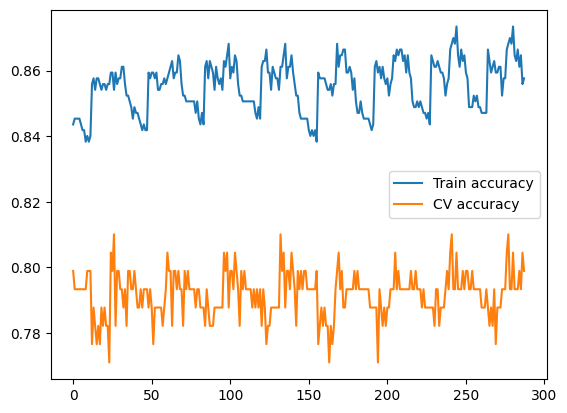

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
train_accuracy = [model[2] for model in model_evals]
cv_accuracy = [model[3] for model in model_evals]
plt.plot(range(len(model_evals)), train_accuracy)
plt.plot(range(len(model_evals)), cv_accuracy)
plt.legend(["Train accuracy", "CV accuracy"])
plt.show()

In [8]:
df_test = pd.read_csv("../data/test.csv", delimiter=",")

best_model = best_model_params[0]
preprocessor = best_model_params[1]
y_test_hat = best_model.predict(preprocessor.transform(df_test))
output = pd.DataFrame({
    "PassengerId": df_test["PassengerId"],
    "Survived": y_test_hat
})
output.to_csv("xgb_submission.csv", index=False)